In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [31]:
!pip install nbconvert
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace your_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [2]:
# Load datasets
train_data = pd.read_csv("/content/Train.csv")
# test_data = pd.read_csv("/content/test_data.csv")


In [3]:
import pandas as pd

# Assuming train_data is already defined
test_data = train_data.sample(n=6584, random_state=42)  # Select random sample
train_data = train_data.drop(test_data.index)  # Remove selected samples from train_data
print(test_data.shape)
print(train_data.shape)  # Verify the remaining train_data size


(6584, 14)
(80000, 14)


In [ ]:
df=train_data.copy()

In [4]:
for col in train_data.columns:
    print(col)
    print (train_data[col].max(), '|',train_data[col].min())
    print('__________________')

ID_Zindi
ID_ZZZAQB | ID_00017O
__________________
Date
9/9/21 | 1/1/19
__________________
ID
X9999 | PD01
__________________
LAT
45.88973369 | 44.92469405
__________________
LON
12.59068235 | 8.736496578
__________________
Precipitation
135.3968048 | 0.0
__________________
LST
327.46 | 253.2
__________________
AAI
2.143020488 | -5.196266174
__________________
CloudFraction
1.000000044 | 0.0
__________________
NO2_strat
7.28e-05 | 1.34e-05
__________________
NO2_total
0.002047452 | -1.19e-05
__________________
NO2_trop
0.001097291 | -2.53e-05
__________________
TropopausePressure
24449.00715 | 8614.349685
__________________
GT_NO2
165.95 | 0.0
__________________


In [30]:
import xgboost
import catboost
import lightgbm

print("XGBoost version:", xgboost.__version__)
print("CatBoost version:", catboost.__version__)
print("LightGBM version:", lightgbm.__version__)


XGBoost version: 2.1.4
CatBoost version: 1.2.8
LightGBM version: 4.5.0


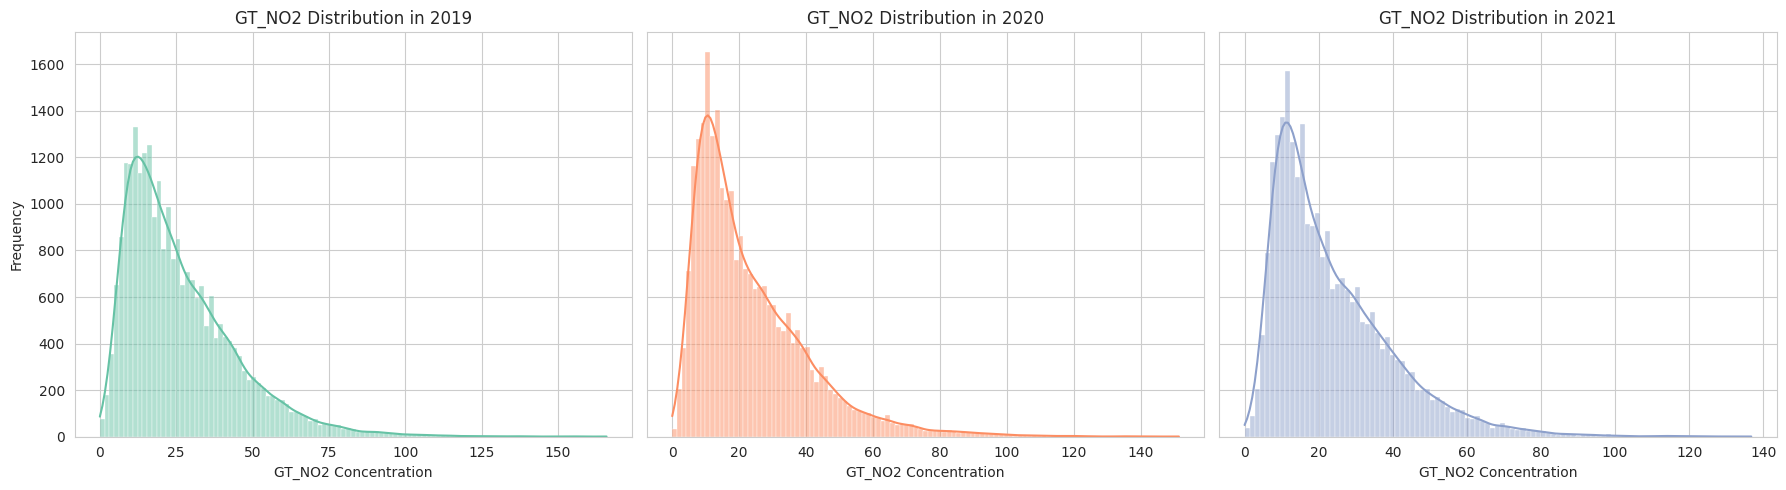

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure Date is parsed correctly
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Extract Year
df['Year'] = df['Date'].dt.year

# Set the plot style
sns.set_style('whitegrid')

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Define the years you want to plot
years = [2019, 2020, 2021]

# Loop through years and plot
for i, year in enumerate(years):
    sns.histplot(
        data=df[df['Year'] == year],
        x='GT_NO2',
        kde=True,
        ax=axes[i],
        color=sns.color_palette('Set2')[i]
    )
    axes[i].set_title(f'GT_NO2 Distribution in {year}')
    axes[i].set_xlabel('GT_NO2 Concentration')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


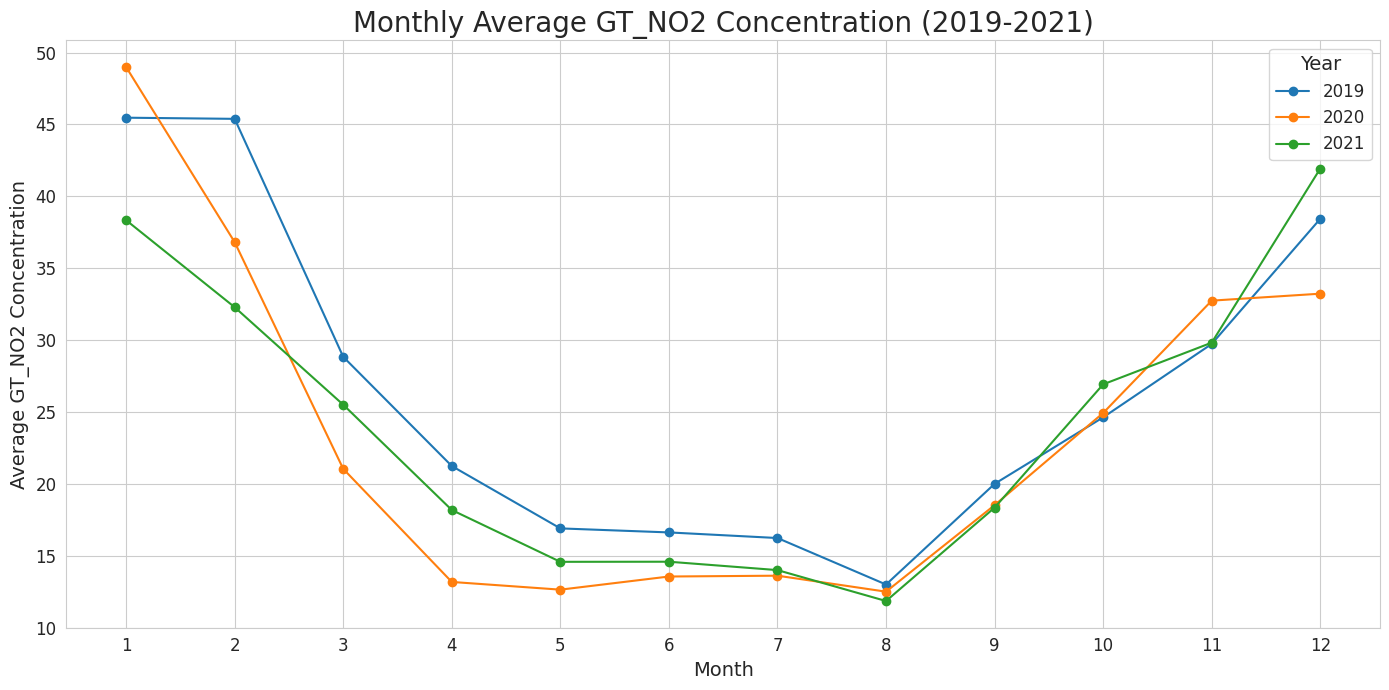

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Date is parsed correctly
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Extract Year and Month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by Year and Month and calculate mean GT_NO2
monthly_avg = df.groupby(['Year', 'Month'])['GT_NO2'].mean().reset_index()

# Set plot style
sns.set_style('whitegrid')

# Create the plot
plt.figure(figsize=(14, 7))

# Plot for each year separately
years = [2019, 2020, 2021]
for year in years:
    subset = monthly_avg[monthly_avg['Year'] == year]
    plt.plot(subset['Month'], subset['GT_NO2'], marker='o', label=str(year))

# Beautify the plot with larger font sizes
plt.title('Monthly Average GT_NO2 Concentration (2019-2021)', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average GT_NO2 Concentration', fontsize=14)
plt.xticks(range(1, 13), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Year', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()


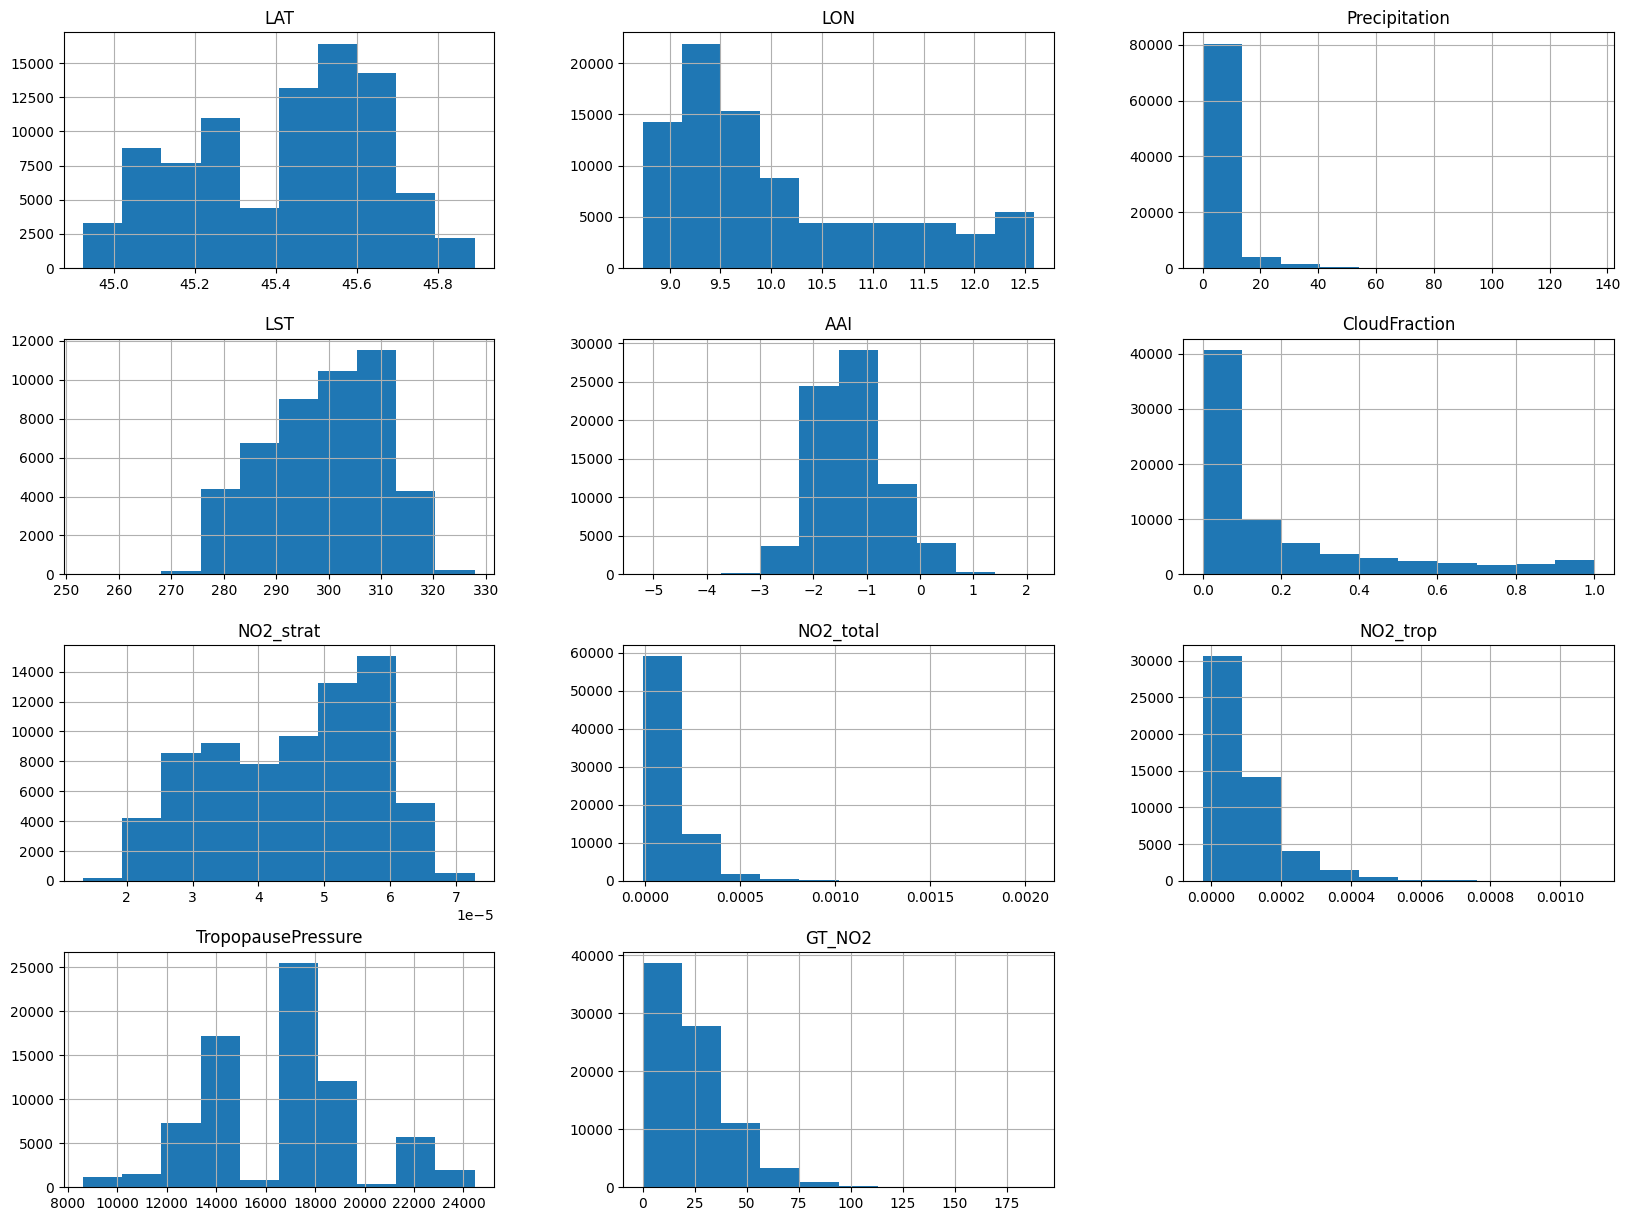

In [ ]:
num_feats = list(train_data.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_data[num_feats].hist(figsize=(20,15));

In [ ]:
# Display first few rows
train_data.head()

ID_Zindi    Date    ID        LAT        LON  Precipitation  LST  \
0  ID_ENTGC7  1/1/19  PD01  45.601585  11.903551       0.000000  NaN   
1  ID_8JCCXC  1/1/19  PD04  45.371005  11.840830       3.047342  NaN   
2  ID_V3136Z  1/1/19  RO01  45.045825  12.060869       0.000000  NaN   
3  ID_KRVZDJ  1/1/19  RO02  45.104075  11.553241       1.200467  NaN   
4  ID_PR351A  1/1/19  RO03  45.038758  11.790152       1.274564  NaN   

        AAI  CloudFraction  NO2_strat  NO2_total  NO2_trop  \
0  0.230527       0.559117   0.000024   0.000117       NaN   
1 -0.074006       0.869309   0.000024   0.000127       NaN   
2  0.024470       0.674160   0.000024   0.000086       NaN   
3 -0.010442       0.920054   0.000024   0.000124       NaN   
4 -0.176178       0.747464   0.000024   0.000116       NaN   

   TropopausePressure  GT_NO2  
0         14440.82126    31.0  
1         14441.79815    42.0  
2         14437.38294    31.0  
3         14440.83831    30.0  
4         14438.79037    58.0

In [ ]:
print(train_data.isnull().sum())
print("-----------------------------------------")
print(test_data.isnull().sum())

ID_Zindi                  0
Date                      1
ID                        1
LAT                       1
LON                       1
Precipitation             1
LST                   13834
AAI                    3962
CloudFraction          3962
NO2_strat              3962
NO2_total              3962
NO2_trop              12312
TropopausePressure     3962
GT_NO2                 1833
dtype: int64
-----------------------------------------
ID_Zindi                 0
Date                     0
ID                       0
LAT                      0
LON                      0
Precipitation            0
LST                   3134
AAI                    832
CloudFraction          832
NO2_strat              832
NO2_total              832
NO2_trop              2742
TropopausePressure     832
GT_NO2                 451
dtype: int64


In [5]:
# storing the ID_Zindi columns in another frames
ID_ZINDI_Train = pd.DataFrame()
ID_ZINDI_Test = pd.DataFrame()
ID_ZINDI_Train['Id_Zindi']=train_data['ID_Zindi']
ID_ZINDI_Test['Id_Zindi']=test_data['ID_Zindi']

**FEATURE ENGINEERING**

In [6]:
# Longitude and Latitude Features
train_data['Mean_LAT_LON'] = train_data[['LAT', 'LON']].mean(axis=1)
test_data['Mean_LAT_LON'] = test_data[['LAT', 'LON']].mean(axis=1)

# Interaction Features
train_data['LST_Precip'] = train_data['LST'] * train_data['Precipitation']
test_data['LST_Precip'] = test_data['LST'] * test_data['Precipitation']

train_data['AAI_Cloud'] = train_data['AAI'] * train_data['CloudFraction']
test_data['AAI_Cloud'] = test_data['AAI'] * test_data['CloudFraction']


In [7]:
# Create spatial bins by rounding latitude and longitude
train_data['LAT_bin'] = train_data['LAT'].round(2)  # Adjust rounding precision as needed
train_data['LON_bin'] = train_data['LON'].round(2)

# Calculate mean NO2 emissions for each spatial bin
mean_no2_by_region = train_data.groupby(['LAT_bin', 'LON_bin'])['GT_NO2'].mean().reset_index()


In [8]:
# Create spatial bins by rounding latitude and longitude
test_data['LAT_bin'] = test_data['LAT'].round(2)  # Adjust rounding precision as needed
test_data['LON_bin'] = test_data['LON'].round(2)

# Calculate mean NO2 emissions for each spatial bin
mean_no2_by_region = test_data.groupby(['LAT_bin', 'LON_bin'])['GT_NO2'].mean().reset_index()


In [11]:
# Calculate global statistics
global_mean = mean_no2_by_region['GT_NO2'].mean()
global_std = mean_no2_by_region['GT_NO2'].std()

# Set threshold for anomalies (e.g., 2 standard deviations away from mean)
threshold_upper = global_mean + 2 * global_std
threshold_lower = global_mean - 2 * global_std

# Identify anomalous bins
anomalous_bins = mean_no2_by_region[
    (mean_no2_by_region['GT_NO2'] > threshold_upper) |
    (mean_no2_by_region['GT_NO2'] < threshold_lower)
]
print("Anomalous regions:", anomalous_bins)

Anomalous regions:     LAT_bin  LON_bin     GT_NO2
41    45.50     9.19  47.730651
53    45.54    10.23  48.605833
55    45.55     9.16  45.479706
56    45.55     9.23  41.345938
58    45.58     9.27  41.818836


In [ ]:
test_data.shape

(6164, 17)

In [10]:
anomalous_bins = anomalous_bins.drop(columns=['GT_NO2'])

# Merge back to the original dataset to identify anomalous rows
train_data = train_data.merge(anomalous_bins, on=['LAT_bin', 'LON_bin'], how='left', indicator=True)
# Keep only non-anomalous rows
train_data = train_data[train_data['_merge'] == 'left_only'].drop(columns=['_merge', 'LAT_bin', 'LON_bin'])


In [12]:
anomalous_bins = anomalous_bins.drop(columns=['GT_NO2'])

# Merge back to the original dataset to identify anomalous rows
test_data = test_data.merge(anomalous_bins, on=['LAT_bin', 'LON_bin'], how='left', indicator=True)
# Keep only non-anomalous rows
test_data = test_data[test_data['_merge'] == 'left_only'].drop(columns=['_merge', 'LAT_bin', 'LON_bin'])


In [14]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

# Forward fill for all columns
train_data.ffill(inplace=True)
test_data.ffill(inplace=True)

numeric_cols = train_data.select_dtypes(include=['number']).columns

# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)  # Using 5 nearest neighbors
train_data[numeric_cols] = knn_imputer.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = knn_imputer.transform(test_data[numeric_cols])

# For categorical columns, use 'Unknown' as a placeholder
non_numeric_cols = train_data.select_dtypes(exclude=['number']).columns
train_data[non_numeric_cols] = train_data[non_numeric_cols].fillna('Unknown')
test_data[non_numeric_cols] = test_data[non_numeric_cols].fillna('Unknown')

print("Missing values handled successfully.")


Missing values handled successfully.


In [13]:
# Convert Date to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Sort by Date
train_data.sort_values(by='Date', inplace=True)
test_data.sort_values(by='Date', inplace=True)

# Extract Year, Month, and Day features
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day

test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day

# Drop the original Date column
train_data.drop('Date', axis=1, inplace=True)
test_data.drop('Date', axis=1, inplace=True)

print("Date column sorted and features extracted successfully.")


<ipython-input-13-3d81fca4bebf>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Date'] = pd.to_datetime(train_data['Date'])
<ipython-input-13-3d81fca4bebf>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['Date'] = pd.to_datetime(test_data['Date'])


Date column sorted and features extracted successfully.


In [15]:
X_train = train_data.drop(['GT_NO2'], axis=1)
y_train = train_data['GT_NO2']
X_test = test_data.drop(['GT_NO2'], axis=1)
y_test = test_data['GT_NO2']

In [16]:
from sklearn.preprocessing import StandardScaler

# Get common numeric columns
common_numeric_cols = X_train.select_dtypes(include=['number']).columns.intersection(
    test_data.select_dtypes(include=['number']).columns
)

print("Common numeric columns:", common_numeric_cols)

# Fit the scaler only on the common numeric columns from train_data
scaler = StandardScaler()
scaler.fit(X_train[common_numeric_cols])

# Transform the same columns in the test_data
X_test[common_numeric_cols] = scaler.transform(X_test[common_numeric_cols])
X_train[common_numeric_cols] = scaler.transform(X_train[common_numeric_cols])


Common numeric columns: Index(['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure',
       'Mean_LAT_LON', 'LST_Precip', 'AAI_Cloud', 'Year', 'Month', 'Day'],
      dtype='object')


Text(0.5, 1.0, 'Feature Correlation Heatmap')

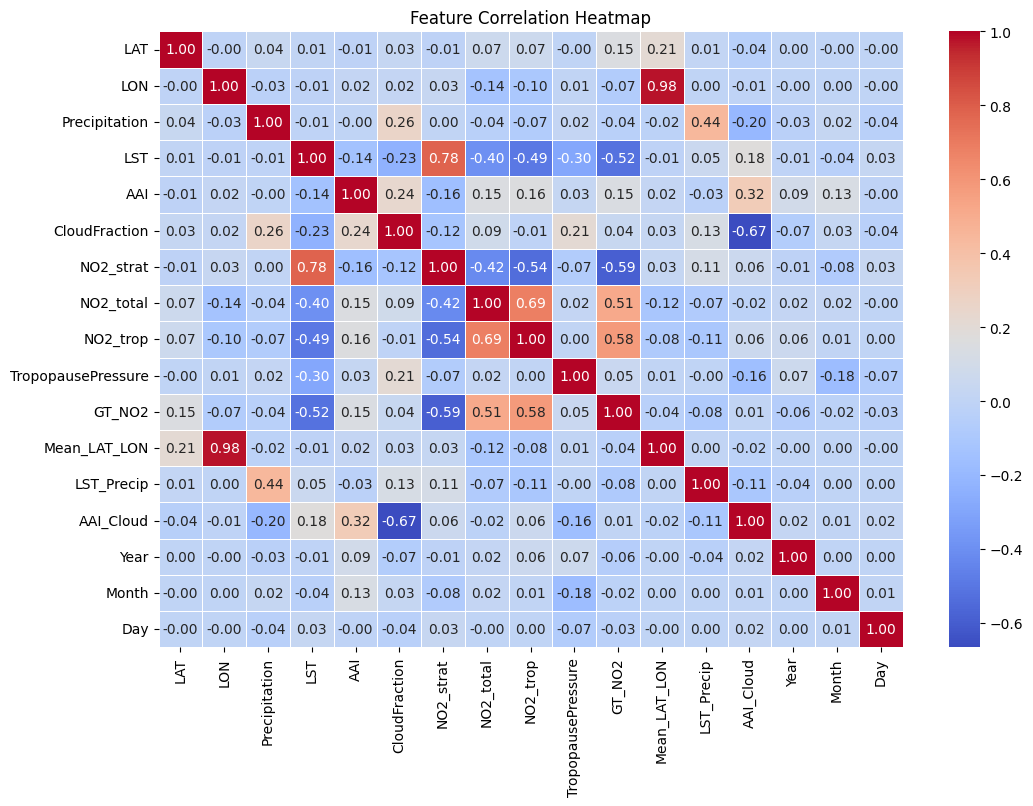

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = train_data.corr()
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))
# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# Title of the heatmap
plt.title("Feature Correlation Heatmap")

In [ ]:
for col in X_train.columns:
    print(col)
    print (X_train[col].max(), '|',X_train[col].min())
    print('======================== ===================')

ID_Zindi
ID_ZZZAQB | ID_00017O
======================== ===================
ID
X9999 | PD01
======================== ===================
LAT
2.0685092624557098 | -2.1213536363904004
======================== ===================
LON
2.364856396874835 | -1.2260902351768228
======================== ===================
Precipitation
17.55322999142029 | -0.3394120322527786
======================== ===================
LST
2.6378461665306934 | -3.518749631620963
======================== ===================
AAI
4.640042518644113 | -5.35004156483515
======================== ===================
CloudFraction
2.703127383278265 | -0.8474470973910702
======================== ===================
NO2_strat
2.2955636444946705 | -2.3657023872689056
======================== ===================
NO2_total
17.54448533054817 | -1.595133731411589
======================== ===================
NO2_trop
11.015882370512864 | -1.4461248351358438
======================== ===================
TropopausePressure
2.5601

In [17]:
X_train = X_train.drop(['ID_Zindi', 'ID'], axis=1)
X_test = X_test.drop(['ID_Zindi', 'ID'], axis=1)

In [ ]:
# Cross-Validation Setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Convert to NumPy arrays
y_train_np = y_train.to_numpy().ravel()
y_test_np = y_test.to_numpy().ravel()
y_train_pred_np = y_train_pred.ravel()
y_test_pred_np = y_test_pred.ravel()

# RMSE Calculation
lr_rmse_train = np.sqrt(mean_squared_error(y_train_np, y_train_pred_np))
lr_rmse_test = np.sqrt(mean_squared_error(y_test_np, y_test_pred_np))

# MAE Calculation
lr_mae_train = mean_absolute_error(y_train_np, y_train_pred_np)
lr_mae_test = mean_absolute_error(y_test_np, y_test_pred_np)

# Pearson Correlation Coefficient
pearson_train = np.corrcoef(y_train_np, y_train_pred_np)[0, 1]
pearson_test = np.corrcoef(y_test_np, y_test_pred_np)[0, 1]

# Print results
print(f"Linear Regression Train RMSE: {lr_rmse_train}")
print(f"Linear Regression Test RMSE: {lr_rmse_test}")
print(f"Linear Regression Train MAE: {lr_mae_train}")
print(f"Linear Regression Test MAE: {lr_mae_test}")
print(f"Linear Regression Train Pearson: {pearson_train}")
print(f"Linear Regression Test Pearson: {pearson_test}")


Linear Regression Train RMSE: 11.272715211250128
Linear Regression Test RMSE: 10.97118959110218
Linear Regression Train MAE: 8.20159709996346
Linear Regression Test MAE: 7.9436633822531695
Linear Regression Train Pearson: 0.700843910845246
Linear Regression Test Pearson: 0.7018374791175551


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# Predictions
y_pred_lr = lr_model.predict(X_test)
# RMSE Calculation
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression Test RMSE: {lr_rmse}")


Linear Regression Test RMSE: 10.968814636856894


In [20]:
from sklearn.experimental import enable_halving_search_cv  # ✅ Must be first
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Define parameter grid
param_grid = {
    'alpha': np.logspace(-4, 4, 50)
}

# Model
ridge = Ridge()

# Halving Grid Search
search = HalvingGridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5, factor=2, verbose=1)
search.fit(X_train, y_train)

# Best model
best_ridge = search.best_estimator_

# Predictions
y_pred = best_ridge.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Ridge Test RMSE: {ridge_rmse}")


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 2341
max_resources_: 74940
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 2341
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 1
n_candidates: 25
n_resources: 4682
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 2
n_candidates: 13
n_resources: 9364
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 3
n_candidates: 7
n_resources: 18728
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 4
n_resources: 37456
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 74912
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Ridge Test RMSE: 10.96814844970617


In [22]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    # Suggest value for alpha
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1e4)

    # Define model with suggested alpha
    model = Ridge(alpha=alpha)

    # Use cross-validation on training set
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    return -1.0 * score.mean()  # Minimize RMSE

# Create and run the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters and model
best_alpha = study.best_params['alpha']
print(f"Best alpha: {best_alpha}")

# Train final model on full training set
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Optuna Ridge Test RMSE: {rmse}")


[I 2025-05-04 05:06:13,745] A new study created in memory with name: no-name-6b1fd7d2-b3ef-4db6-a85e-8e26125d85f6
<ipython-input-22-b4c41ec106ad>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 1e4)
[I 2025-05-04 05:06:13,965] Trial 0 finished with value: 133.95360187590566 and parameters: {'alpha': 4.7811658857921495}. Best is trial 0 with value: 133.95360187590566.
<ipython-input-22-b4c41ec106ad>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 1e4)
[I 2025-05-04 05:06:14,404] Trial 1 finished with value: 133.93116366388136 and parameters: {'alpha': 124.7363195061519}. Bes

Best alpha: 6487.287054603046
Optuna Ridge Test RMSE: 10.976538287051836


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

# Create a Spline Transformer
spline_reg = make_pipeline(
    SplineTransformer(degree=3, n_knots=5, include_bias=False),
    LinearRegression()
)
# Train Spline Regression model
spline_reg.fit(X_train, y_train)
# Predictions
y_pred_spline = spline_reg.predict(X_test)
# RMSE Calculation
spline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_spline))
print(f"Spline Regression Test RMSE: {spline_rmse}")


Spline Regression Test RMSE: 10.315070604523116


In [ ]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

# Apply B-Spline transformation
spline_transformer = SplineTransformer(n_knots=5, degree=3, include_bias=False)
# Define model pipeline
spline_model = make_pipeline(spline_transformer, RandomForestRegressor(n_estimators=100))
# Train model
spline_model.fit(X_train, y_train)
# Predict
y_pred_spline = spline_model.predict(X_test)
# RMSE Calculation
spline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_spline))
print(f"Spline Regression RMSE: {spline_rmse}")


Spline Regression RMSE: 8.4211169593435


In [ ]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# Apply B-Spline transformation
spline_transformer = SplineTransformer(n_knots=5, degree=3, include_bias=False)
# Define model pipeline
spline_model = make_pipeline(spline_transformer, RandomForestRegressor(n_estimators=100))
# Train model
spline_model.fit(X_train, y_train)
# Predict
y_pred_spline = spline_model.predict(X_test)
# RMSE Calculation
spline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_spline))
# MAE Calculation
spline_mae = mean_absolute_error(y_test, y_pred_spline)
# Print results
print(f"Spline Regression RMSE: {spline_rmse}")
print(f"Spline Regression MAE: {spline_mae}")

Spline Regression RMSE: 8.404658763208715
Spline Regression MAE: 5.763661272434618


In [ ]:
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Define optimized pipeline
spline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('spline', SplineTransformer(n_knots=10, degree=3, include_bias=False)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42))
])

# Train model
spline_model.fit(X_train, y_train)

# Cross-validation RMSE
rmse_scores = -cross_val_score(spline_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-Validation RMSE: {rmse_scores.mean():.4f}")

# Predict on test set
y_pred_spline = spline_model.predict(X_test)

# RMSE Calculation
from sklearn.metrics import mean_squared_error
spline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_spline))
print(f"Spline Regression RMSE on Test Set: {spline_rmse:.4f}")


Cross-Validation RMSE: 10.0826
Spline Regression RMSE on Test Set: 9.2402


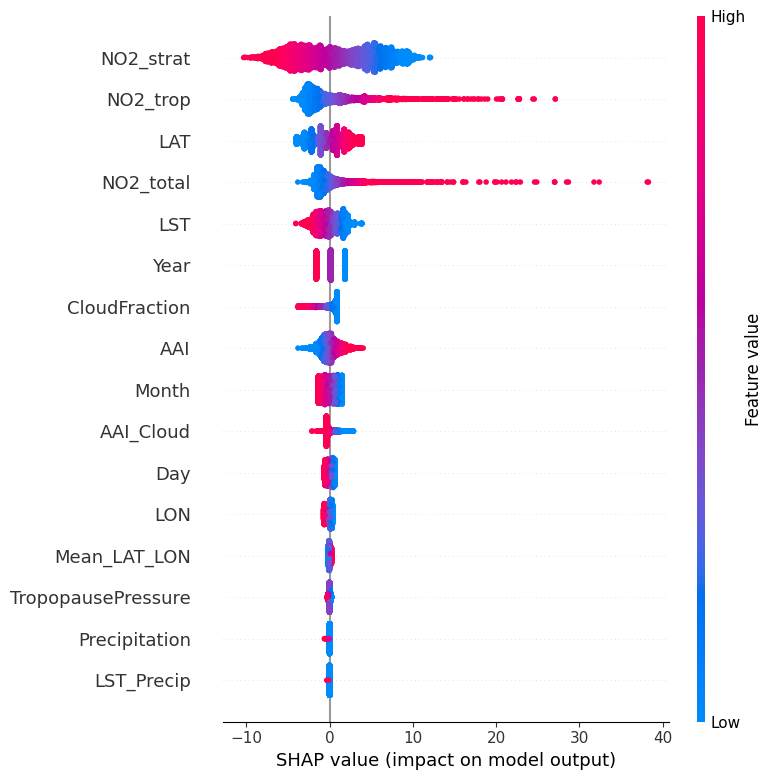

In [ ]:
import shap

# Initialize SHAP explainer
explainer_lr = shap.Explainer(lr_model, X_train)

# Compute SHAP values
shap_values_lr = explainer_lr(X_test)

# Summary Plot
shap.summary_plot(shap_values_lr, X_test)



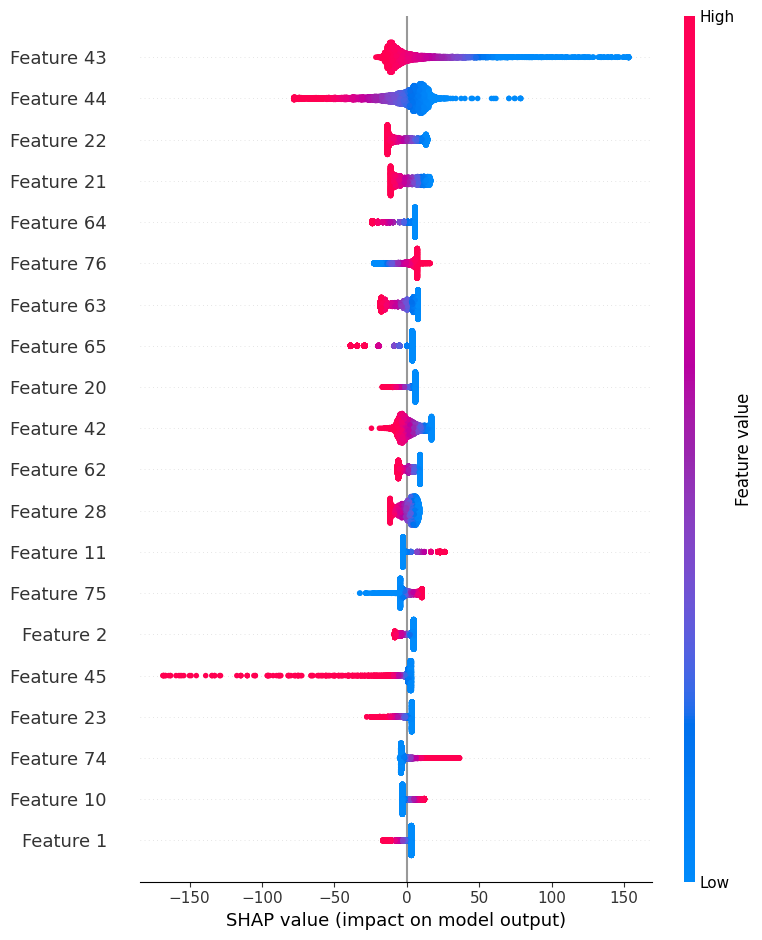

In [ ]:
import numpy as np
import shap

# Get transformed features from the pipeline
X_train_transformed = spline_reg.named_steps['splinetransformer'].transform(X_train)
X_test_transformed = spline_reg.named_steps['splinetransformer'].transform(X_test)

# Fit SHAP Explainer on the linear regression model
explainer_spline = shap.Explainer(spline_reg.named_steps['linearregression'], X_train_transformed)

# Compute SHAP values
shap_values_spline = explainer_spline(X_test_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values_spline, X_test_transformed)


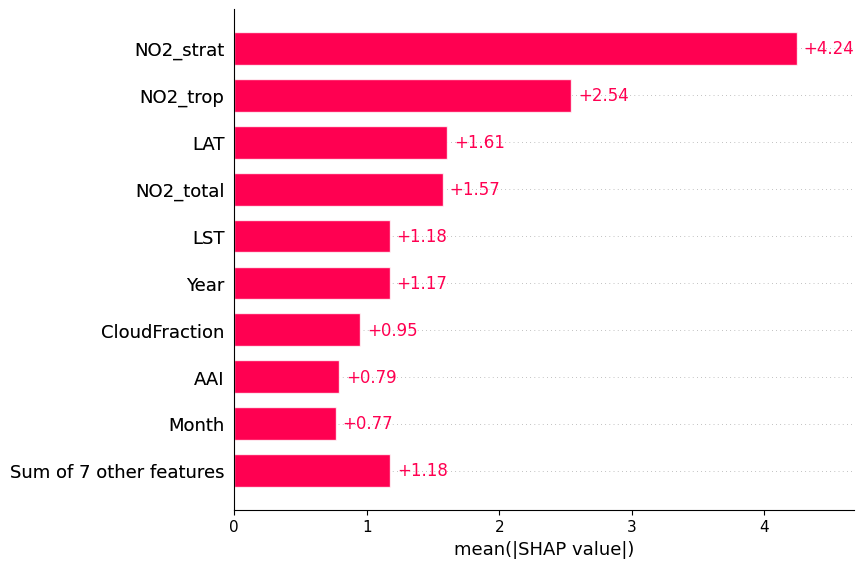

In [ ]:
shap.plots.bar(shap_values_lr)  # For Linear Regression
# shap.plots.bar(shap_values_spline)  # For Spline Regression

**Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree Regressor
dtr_model = DecisionTreeRegressor(max_depth=5, random_state=42)
# Train DTR Model
dtr_model.fit(X_train, y_train)
# Predictions
y_pred_dtr = dtr_model.predict(X_test)
# RMSE Calculation
dtr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dtr))
print(f"Decision Tree Regression Test RMSE: {dtr_rmse}")

Decision Tree Regression Test RMSE: 10.860404935241448


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# Initialize Decision Tree Regressor
dtr_model = DecisionTreeRegressor(max_depth=5, random_state=42)
# Train DTR Model
dtr_model.fit(X_train, y_train)
# Predictions
y_pred_dtr = dtr_model.predict(X_test)
# RMSE Calculation
dtr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dtr))
# MAE Calculation
dtr_mae = mean_absolute_error(y_test, y_pred_dtr)
# Print results
print(f"Decision Tree Regression Test RMSE: {dtr_rmse}")
print(f"Decision Tree Regression Test MAE: {dtr_mae}")


Decision Tree Regression Test RMSE: 10.860404935241448
Decision Tree Regression Test MAE: 7.7933703699736805


In [25]:
from sklearn.experimental import enable_halving_search_cv  # Required for enabling
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model
dtr = DecisionTreeRegressor(random_state=42)

# Halving Grid Search
search = HalvingGridSearchCV(dtr, param_grid, cv=5, factor=2, scoring='neg_mean_squared_error', verbose=1)
search.fit(X_train, y_train)

# Best model
best_dtr = search.best_estimator_

# Prediction and evaluation
y_pred = best_dtr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print RMSE, MAE, and tuned parameters
print(f"Best DTR RMSE: {rmse}")
print(f"Best DTR MAE: {mae}")
print("Tuned Hyperparameters: ", search.best_params_)


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 2341
max_resources_: 74940
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 2341
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 18
n_resources: 4682
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 9
n_resources: 9364
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 5
n_resources: 18728
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 3
n_resources: 37456
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 74912
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best DTR RMSE: 10.863686519135184
Best DTR MAE: 7.794186294243275
Tuned Hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [ ]:
import shap

# Create SHAP explainer for Decision Tree
explainer = shap.Explainer(dtr_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)


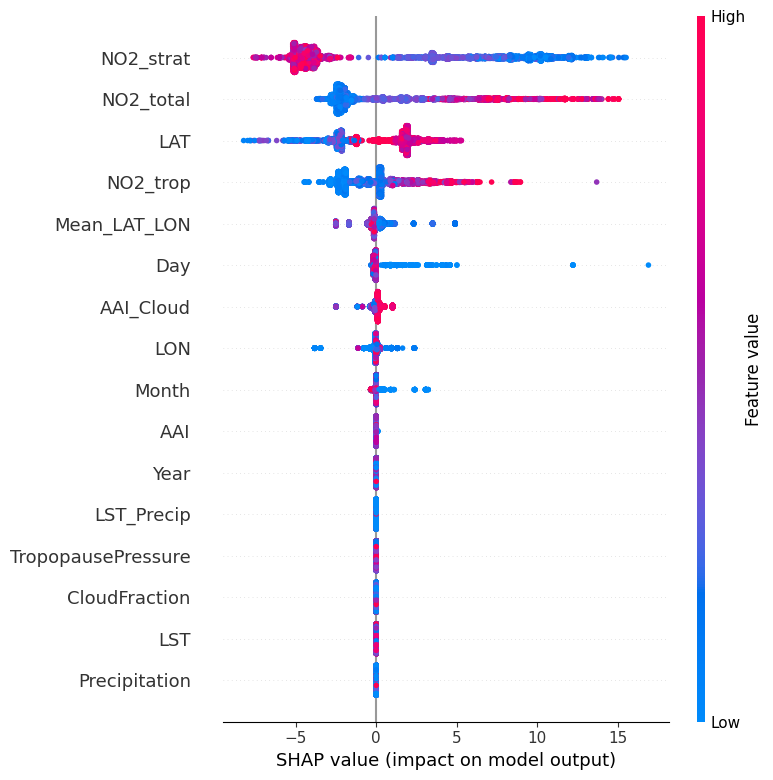

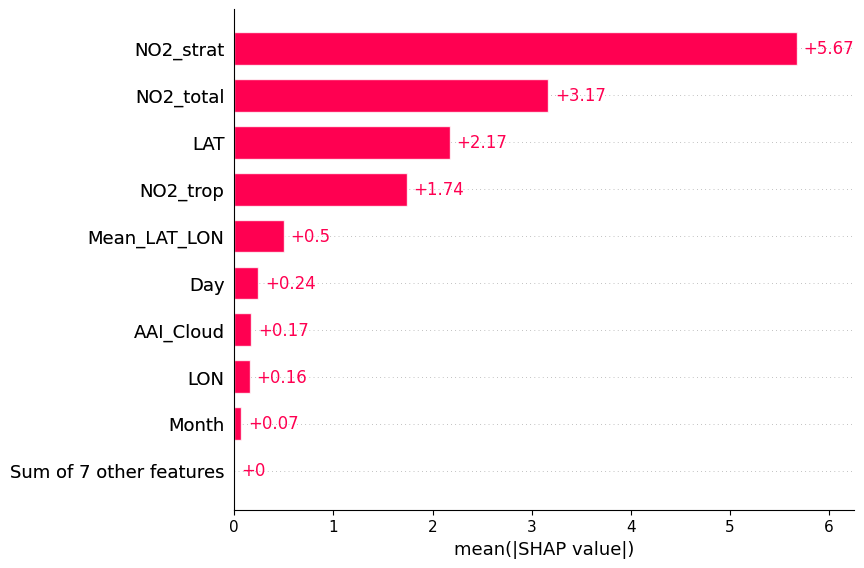

In [ ]:
# Summary plot - Overall feature impact
shap.summary_plot(shap_values, X_test)
shap.plots.bar(shap_values)

**Random Forest Regressor**

In [ ]:
rf_model = RandomForestRegressor(random_state=42)  # Create a new model instance
rf_model.fit(X_train, y_train)  # Train on full training data

# ---- Evaluate on Training Data ----
y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse}")

Training RMSE: 2.9072260494882447


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# ---- Evaluate on Test Data ----
y_test_pred = rf_model.predict(X_test)
# RMSE Calculation
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
# MAE Calculation
test_mae = mean_absolute_error(y_test, y_test_pred)
# Print results
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")


Test RMSE: 8.418799799512792
Test MAE: 5.786878515026946


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
# Initialize model
rf_model = RandomForestRegressor(random_state=42)
# Randomized Search
rf_random = RandomizedSearchCV(rf_model, param_grid, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
rf_random.fit(X_train, y_train)
# Best model
best_rf = rf_random.best_estimator_
# Evaluate
y_test_pred = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Optimized Test RMSE: {test_rmse}")


Optimized Test RMSE: 8.441388457341535


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Randomized Search
rf_random = RandomizedSearchCV(rf_model, param_grid, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
rf_random.fit(X_train, y_train)

# Best model
best_rf = rf_random.best_estimator_

# Evaluate
y_test_pred = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print RMSE and tuned hyperparameters
print(f"Optimized Test RMSE: {test_rmse}")
print("Tuned Hyperparameters: ", rf_random.best_params_)


Optimized Test RMSE: 8.35269754477543
Tuned Hyperparameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


**Gradient Booster Regressor**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [500],
    'learning_rate': [0.05],
    'max_depth': [6],
    'subsample': [0.8]
}
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gb_model = grid_search.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
best_gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))
print(f"Optimized Gradient Boosting Test RMSE: {best_gb_rmse}")

Optimized Gradient Boosting Test RMSE: 8.015525790386926


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [500],
    'learning_rate': [0.05],
    'max_depth': [6],
    'subsample': [0.8]
}

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions
y_pred_best_gb = best_gb_model.predict(X_test)

# RMSE Calculation
best_gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))

# MAE Calculation
best_gb_mae = mean_absolute_error(y_test, y_pred_best_gb)

# Print results
print(f"Optimized Gradient Boosting Test RMSE: {best_gb_rmse}")
print(f"Optimized Gradient Boosting Test MAE: {best_gb_mae}")


Optimized Gradient Boosting Test RMSE: 8.015525790386926
Optimized Gradient Boosting Test MAE: 5.614510907546724


100%|===================| 6135/6164 [02:59<00:00]       

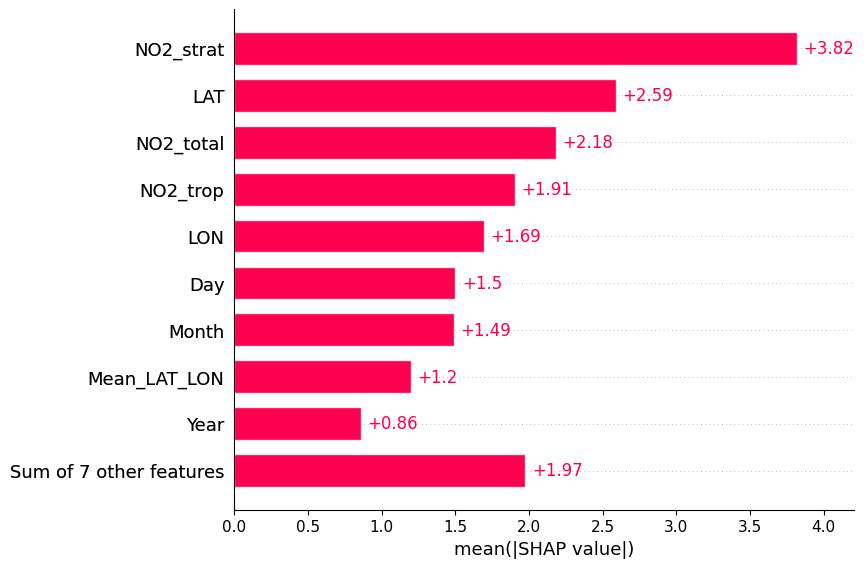

In [ ]:
import shap
# ----- SHAP Explanation (Fix for Additivity Error) -----
explainer_gb = shap.Explainer(xgb_model, X_train)
shap_values_gb = explainer_gb(X_test, check_additivity=False)  # ✅ Fix additivity error

# Feature Importance Bar Chart
shap.plots.bar(shap_values_gb)


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost Test RMSE: {xgb_rmse}")

XGBoost Test RMSE: 7.930908724325982


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.12, max_depth=9)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost Test RMSE: {xgb_rmse}")

XGBoost Test RMSE: 7.396888227523099


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=12000, learning_rate=0.05, max_depth=7,
                         colsample_bytree=0.8, subsample=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=0.5)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost Test RMSE: {xgb_rmse}")

XGBoost Test RMSE: 7.346063013031406


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=12000, learning_rate=0.05, max_depth=7,
                         colsample_bytree=0.8, subsample=0.8, gamma=0.1,
                         reg_alpha=0.1, reg_lambda=0.5)
# Train the model
xgb_model.fit(X_train, y_train)
# Predictions
y_pred_xgb = xgb_model.predict(X_test)
# RMSE Calculation
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
# MAE Calculation
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
# Print results
print(f"XGBoost Test RMSE: {xgb_rmse}")
print(f"XGBoost Test MAE: {xgb_mae}")


XGBoost Test RMSE: 7.346063013031406
XGBoost Test MAE: 4.97064637664951


XGBoost Test RMSE: 7.396888227523099


100%|===================| 6158/6164 [13:27<00:00]       

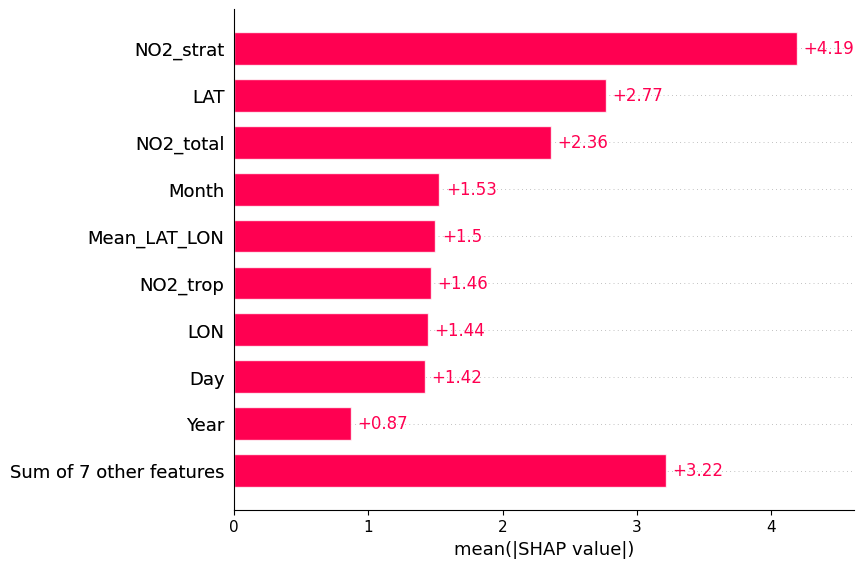

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.12, max_depth=9)
xgb_model.fit(X_train, y_train)
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
# Compute RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost Test RMSE: {xgb_rmse}")
# ----- SHAP Explanation -----
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)
# Feature Importance Bar Chart
shap.plots.bar(shap_values_xgb)


**LSTM**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4684/4684 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 246.5064 - val_loss: 193.9839 - learning_rate: 0.0010
Epoch 2/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 115.5955 - val_loss: 187.2710 - learning_rate: 0.0010
Epoch 3/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 106.3466 - val_loss: 183.1580 - learning_rate: 0.0010
Epoch 4/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 103.7427 - val_loss: 178.7896 - learning_rate: 0.0010
Epoch 5/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 102.2668 - val_loss: 178.4335 - learning_rate: 0.0010
Epoch 6/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 100.0231 - val_loss: 174.4108 - learning_rate: 0.0010
Epoch 7/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 99.5055 - val_loss: 174.9106 - learning_rate: 0.0010
Epoch 8/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 95.2447 - val_loss: 172.0726 - learning_rate: 0.0010
Epoch 9/100
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 96.229

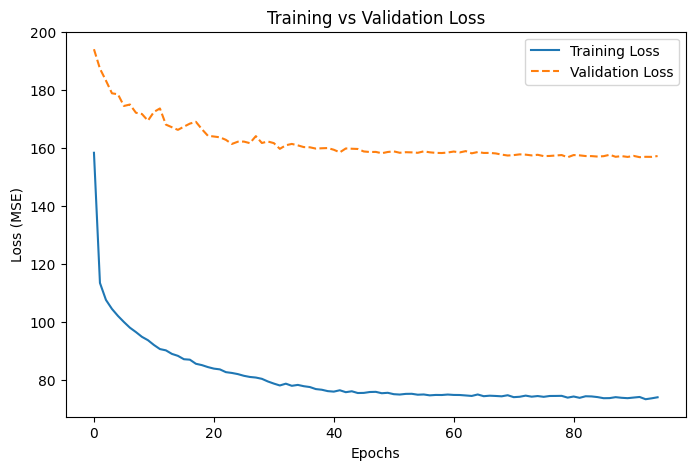

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reshape data to 3D for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM model with Dropout
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.3),  # Add dropout to prevent overfitting
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])

# Compile model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# EarlyStopping & ReduceLROnPlateau Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train model with validation data
history = model.fit(
    X_train_reshaped, y_train,
    epochs=50, batch_size=16, verbose=1,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Predict
y_pred_lstm = model.predict(X_test_reshaped)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

print(f"LSTM Test RMSE: {lstm_rmse:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Reshape data to 3D for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=1)

# Predict
y_pred_lstm = model.predict(X_test_reshaped)

# RMSE Calculation
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

# MAE Calculation
lstm_mae = mean_absolute_error(y_test, y_pred_lstm)

# Print results
print(f"LSTM Test RMSE: {lstm_rmse}")
print(f"LSTM Test MAE: {lstm_mae}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 184.8025
Epoch 2/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 107.9496
Epoch 3/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 100.4917
Epoch 4/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 94.9255
Epoch 5/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 90.5821
Epoch 6/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 89.2525
Epoch 7/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 86.8340
Epoch 8/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 83.5012
Epoch 9/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 82.7255
Epoch 10/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 79.6584
Epoch 11/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 79.5578
Epoch 12/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 77.3719
Epoch 13/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 77.0818
Epoch 14/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 75.189

In [ ]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Reshape data to 3D for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
# Define LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=1)
# Predict
y_pred_lstm = model.predict(X_test_reshaped)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f"LSTM Test RMSE: {lstm_rmse}")
# ----- SHAP Explanation -----
# Wrapper function to reshape input
def model_predict(X):
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # Convert to 3D
    return model.predict(X_reshaped).flatten()  # Flatten output
# Select a small subset for SHAP computation
X_sample = X_train[:100]  # Use first 100 samples

# Create SHAP Kernel Explainer
explainer = shap.KernelExplainer(model_predict, X_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_test[:50])  # Explain first 50 test samples

# Convert SHAP values to match feature shape
shap_values = np.array(shap_values).reshape((50, X_train.shape[1]))

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test[:50])
shap.plots.bar(shap_values)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4684/4684 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 190.9013
Epoch 2/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 106.4777
Epoch 3/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 100.8343
Epoch 4/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 95.4721
Epoch 5/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 88.7900
Epoch 6/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 88.8344
Epoch 7/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 84.3746
Epoch 8/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 82.7306
Epoch 9/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 80.4892
Epoch 10/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 79.7434
Epoch 11/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 77.4975
Epoch 12/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 77.1962
Epoch 13/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 75.5161
Epoch 14/50
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 74.1123
Epoch 15/

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

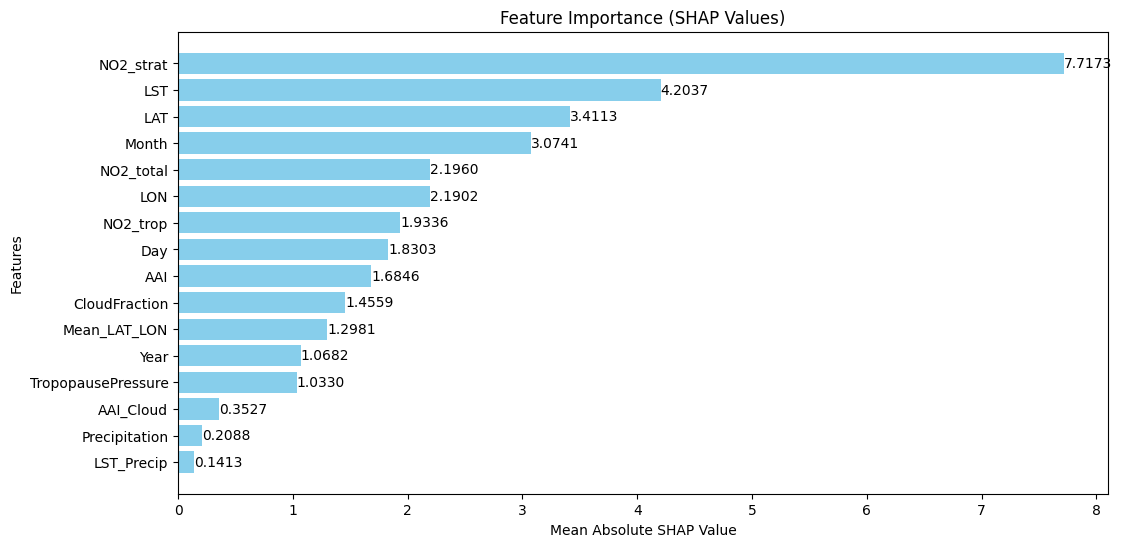

In [ ]:
shap_values_mean = np.abs(shap_values).mean(axis=0)
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(shap_values_mean)[::-1]  # Sort in descending order
sorted_shap_values = shap_values_mean[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# SHAP Bar Plot with Values
plt.figure(figsize=(12, 6))
bars = plt.barh(sorted_feature_names, sorted_shap_values, color='skyblue')

# Display values on bars
for bar, value in zip(bars, sorted_shap_values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{value:.4f}", va='center')

plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Features")
plt.title("Feature Importance (SHAP Values)")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

**Catboost Regressor**

In [ ]:
from catboost import CatBoostRegressor

# Initialize CatBoost Regressor
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

# Train model
cat_model.fit(X_train, y_train)

# Predictions
y_pred_cat = cat_model.predict(X_test)

# RMSE Calculation
cat_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print(f"CatBoost RMSE: {cat_rmse}")


0:	learn: 15.0144987	total: 31.5ms	remaining: 31.4s
100:	learn: 8.7800387	total: 3.23s	remaining: 28.7s
200:	learn: 8.2054272	total: 6s	remaining: 23.9s
300:	learn: 7.8255279	total: 10.1s	remaining: 23.6s
400:	learn: 7.5509061	total: 12.8s	remaining: 19.1s
500:	learn: 7.3313766	total: 15.6s	remaining: 15.5s
600:	learn: 7.1499015	total: 18.3s	remaining: 12.2s
700:	learn: 7.0015897	total: 23.2s	remaining: 9.88s
800:	learn: 6.8759035	total: 24.6s	remaining: 6.11s
900:	learn: 6.7591651	total: 26s	remaining: 2.86s
999:	learn: 6.6494909	total: 27.4s	remaining: 0us
CatBoost RMSE: 7.7934144998280805


In [ ]:
!pip uninstall catboost -y
!pip install catboost


Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize CatBoost Regressor
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

# Train model
cat_model.fit(X_train, y_train)

# Predictions
y_pred_cat = cat_model.predict(X_test)

# RMSE Calculation
cat_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))

# MAE Calculation
cat_mae = mean_absolute_error(y_test, y_pred_cat)

# Print results
print(f"CatBoost RMSE: {cat_rmse}")
print(f"CatBoost MAE: {cat_mae}")


0:	learn: 15.0144987	total: 66.9ms	remaining: 1m 6s
100:	learn: 8.7800387	total: 1.99s	remaining: 17.7s
200:	learn: 8.2054272	total: 3.39s	remaining: 13.5s
300:	learn: 7.8255279	total: 4.84s	remaining: 11.2s
400:	learn: 7.5509061	total: 6.25s	remaining: 9.34s
500:	learn: 7.3313766	total: 8.43s	remaining: 8.4s
600:	learn: 7.1499015	total: 10.7s	remaining: 7.1s
700:	learn: 7.0015897	total: 12.1s	remaining: 5.16s
800:	learn: 6.8759035	total: 13.5s	remaining: 3.35s
900:	learn: 6.7591651	total: 14.9s	remaining: 1.64s
999:	learn: 6.6494909	total: 16.3s	remaining: 0us
CatBoost RMSE: 7.7934144998280805
CatBoost MAE: 5.443118689826264


In [ ]:
cat_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    random_strength=1,
    verbose=100
)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Mean RMSE:", -scores.mean())


0:	learn: 14.7295857	total: 135ms	remaining: 3m 23s
100:	learn: 8.2954048	total: 5.76s	remaining: 1m 19s
200:	learn: 7.6418948	total: 9.72s	remaining: 1m 2s
300:	learn: 7.2307101	total: 14.4s	remaining: 57.2s
400:	learn: 6.8932249	total: 19.9s	remaining: 54.5s
500:	learn: 6.6435168	total: 23.5s	remaining: 46.9s
600:	learn: 6.4339085	total: 25.6s	remaining: 38.3s
700:	learn: 6.2553749	total: 27.7s	remaining: 31.6s
800:	learn: 6.1039710	total: 32s	remaining: 27.9s
900:	learn: 5.9586007	total: 34.1s	remaining: 22.7s
1000:	learn: 5.8306498	total: 36.3s	remaining: 18.1s
1100:	learn: 5.7236221	total: 38.4s	remaining: 13.9s
1200:	learn: 5.6230536	total: 40.5s	remaining: 10.1s
1300:	learn: 5.5322683	total: 43.7s	remaining: 6.68s
1400:	learn: 5.4409677	total: 46.9s	remaining: 3.31s
1499:	learn: 5.3574970	total: 49s	remaining: 0us
0:	learn: 14.6198636	total: 28.1ms	remaining: 42.1s
100:	learn: 8.2510300	total: 2.11s	remaining: 29.3s
200:	learn: 7.6174092	total: 4.18s	remaining: 27s
300:	learn: 7

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Assuming X_train, y_train, X_test, y_test are already defined

# Initialize and train the CatBoost model
cat_model = CatBoostRegressor(iterations=8000, learning_rate=0.1, depth=8)
cat_model.fit(X_train, y_train)

# Predictions
y_pred_test = cat_model.predict(X_test)

# Compute Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE: {test_rmse}")


Streaming output truncated to the last 5000 lines.
3001:	learn: 4.0737345	total: 2m	remaining: 3m 20s
3002:	learn: 4.0732987	total: 2m	remaining: 3m 20s
3003:	learn: 4.0721264	total: 2m	remaining: 3m 20s
3004:	learn: 4.0718027	total: 2m	remaining: 3m 20s
3005:	learn: 4.0713665	total: 2m	remaining: 3m 20s
3006:	learn: 4.0707171	total: 2m	remaining: 3m 20s
3007:	learn: 4.0700187	total: 2m	remaining: 3m 20s
3008:	learn: 4.0697408	total: 2m	remaining: 3m 20s
3009:	learn: 4.0691835	total: 2m	remaining: 3m 20s
3010:	learn: 4.0687744	total: 2m	remaining: 3m 20s
3011:	learn: 4.0684360	total: 2m	remaining: 3m 20s
3012:	learn: 4.0679983	total: 2m	remaining: 3m 20s
3013:	learn: 4.0674433	total: 2m 1s	remaining: 3m 20s
3014:	learn: 4.0672327	total: 2m 1s	remaining: 3m 20s
3015:	learn: 4.0663784	total: 2m 1s	remaining: 3m 20s
3016:	learn: 4.0661749	total: 2m 1s	remaining: 3m 20s
3017:	learn: 4.0657745	total: 2m 1s	remaining: 3m 20s
3018:	learn: 4.0650992	total: 2m 1s	remaining: 3m 20s
3019:	learn: 

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# DataFrame to store results
results = []
# Function to train and evaluate different trials
def run_trial(trial_no, iterations, learning_rate, depth, l2_leaf_reg, bagging_temperature, loss_function='RMSE'):
    global results  # To store all trials
    print(f"\n🔹 Running Trial {trial_no} ...")
    # Initialize model with given hyperparameters
    cat_model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        loss_function=loss_function,
        early_stopping_rounds=100,  # To prevent overfitting
        verbose=200
    )
    # Train the model
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=200)
    # Predictions
    y_pred_test = cat_model.predict(X_test)
    # Compute RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"✅ Trial {trial_no} - Test RMSE: {test_rmse:.4f}")
    # Store results
    results.append({
        'Trial': trial_no,
        'Iterations': iterations,
        'Learning Rate': learning_rate,
        'Depth': depth,
        'L2 Leaf Reg': l2_leaf_reg,
        'Bagging Temperature': bagging_temperature,
        'Loss Function': loss_function,
        'Test RMSE': test_rmse
    })
    return test_rmse


In [ ]:
# Running multiple trials with different hyperparameters
run_trial(1, iterations=5000, learning_rate=0.1, depth=8, l2_leaf_reg=3, bagging_temperature=1)
run_trial(2, iterations=6000, learning_rate=0.05, depth=10, l2_leaf_reg=5, bagging_temperature=2)
run_trial(3, iterations=7000, learning_rate=0.03, depth=6, l2_leaf_reg=2, bagging_temperature=1.5)
run_trial(4, iterations=8000, learning_rate=0.01, depth=12, l2_leaf_reg=7, bagging_temperature=0.8)



🔹 Running Trial 1 ...
0:	learn: 14.9865559	test: 14.6506177	best: 14.6506177 (0)	total: 66.9ms	remaining: 5m 34s
200:	learn: 7.5085053	test: 8.1998203	best: 8.1998203 (200)	total: 9.51s	remaining: 3m 47s
400:	learn: 6.7312476	test: 7.7524744	best: 7.7524744 (400)	total: 17.4s	remaining: 3m 19s
600:	learn: 6.2443452	test: 7.5449616	best: 7.5449616 (600)	total: 23.1s	remaining: 2m 48s
800:	learn: 5.9048118	test: 7.4317227	best: 7.4317227 (800)	total: 28.2s	remaining: 2m 27s
1000:	learn: 5.6259183	test: 7.3567169	best: 7.3561798 (999)	total: 32.8s	remaining: 2m 11s
1200:	learn: 5.3924677	test: 7.3011437	best: 7.3011437 (1200)	total: 38.9s	remaining: 2m 3s
1400:	learn: 5.1807907	test: 7.2609671	best: 7.2609671 (1400)	total: 43.6s	remaining: 1m 51s
1600:	learn: 4.9876364	test: 7.2232203	best: 7.2231158 (1597)	total: 52.6s	remaining: 1m 51s
1800:	learn: 4.8133681	test: 7.1883699	best: 7.1883699 (1800)	total: 1m 5s	remaining: 1m 55s
2000:	learn: 4.6687027	test: 7.1669798	best: 7.1669798 (200

7.110379136534215

In [ ]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
# Sort by lowest Test RMSE
results_df = results_df.sort_values(by="Test RMSE")
# Display results
print(results_df)

   Trial  Iterations  Learning Rate  Depth  L2 Leaf Reg  Bagging Temperature  \
1      2        6000           0.05     10            5                  2.0   
0      1        5000           0.10      8            3                  1.0   
3      4        8000           0.01     12            7                  0.8   
2      3        7000           0.03      6            2                  1.5   

  Loss Function  Test RMSE  
1          RMSE   7.007567  
0          RMSE   7.078300  
3          RMSE   7.110379  
2          RMSE   7.431786  


In [ ]:
run_trial(5, iterations=6500, learning_rate=0.04, depth=9, l2_leaf_reg=4, bagging_temperature=2.5)
run_trial(6, iterations=6000, learning_rate=0.05, depth=11, l2_leaf_reg=6, bagging_temperature=1.8)



🔹 Running Trial 5 ...
0:	learn: 15.4698027	test: 15.0916450	best: 15.0916450 (0)	total: 82.4ms	remaining: 8m 55s
200:	learn: 8.2075956	test: 8.7001336	best: 8.7001336 (200)	total: 14s	remaining: 7m 18s
400:	learn: 7.4507522	test: 8.1693836	best: 8.1693836 (400)	total: 23.3s	remaining: 5m 55s
600:	learn: 6.9712491	test: 7.8888351	best: 7.8888351 (600)	total: 30.9s	remaining: 5m 3s
800:	learn: 6.6167142	test: 7.7126131	best: 7.7126131 (800)	total: 38s	remaining: 4m 30s
1000:	learn: 6.3388076	test: 7.5946547	best: 7.5946547 (1000)	total: 46s	remaining: 4m 12s
1200:	learn: 6.1088932	test: 7.5084492	best: 7.5083622 (1199)	total: 52.7s	remaining: 3m 52s
1400:	learn: 5.9065182	test: 7.4343219	best: 7.4343219 (1400)	total: 1m	remaining: 3m 41s
1600:	learn: 5.7168707	test: 7.3714562	best: 7.3714562 (1600)	total: 1m 7s	remaining: 3m 27s
1800:	learn: 5.5615370	test: 7.3262918	best: 7.3262918 (1800)	total: 1m 15s	remaining: 3m 16s
2000:	learn: 5.4216702	test: 7.2912777	best: 7.2908071 (1997)	tota

7.022452881339512

In [ ]:
run_trial(8, iterations=6000, learning_rate=0.05, depth=10,
          l2_leaf_reg=5, bagging_temperature=2.0,
          loss_function='Huber:delta=1.0')



🔹 Running Trial 8 ...
0:	learn: 18.0421355	test: 17.4616761	best: 17.4616761 (0)	total: 126ms	remaining: 12m 36s
200:	learn: 5.7343600	test: 6.1447963	best: 6.1447963 (200)	total: 20.7s	remaining: 9m 56s
400:	learn: 5.0560780	test: 5.6431003	best: 5.6431003 (400)	total: 33.5s	remaining: 7m 48s
600:	learn: 4.6843920	test: 5.4093031	best: 5.4093031 (600)	total: 46.3s	remaining: 6m 56s
800:	learn: 4.4280716	test: 5.2664189	best: 5.2664189 (800)	total: 59.7s	remaining: 6m 27s
1000:	learn: 4.2223709	test: 5.1545428	best: 5.1545428 (1000)	total: 1m 12s	remaining: 6m 2s
1200:	learn: 4.0549670	test: 5.0776791	best: 5.0776791 (1200)	total: 1m 26s	remaining: 5m 44s
1400:	learn: 3.9176618	test: 5.0153888	best: 5.0153888 (1400)	total: 1m 39s	remaining: 5m 25s
1600:	learn: 3.8004987	test: 4.9630563	best: 4.9630563 (1600)	total: 1m 52s	remaining: 5m 8s
1800:	learn: 3.6960328	test: 4.9203103	best: 4.9203103 (1800)	total: 2m 5s	remaining: 4m 52s
2000:	learn: 3.6041285	test: 4.8870972	best: 4.8870972 

7.6023984504441335

In [ ]:
run_trial(9, iterations=6000, learning_rate=0.05, depth=10, l2_leaf_reg=10, bagging_temperature=2.0)
run_trial(10, iterations=6000, learning_rate=0.05, depth=10, l2_leaf_reg=3, bagging_temperature=2.0)


🔹 Running Trial 9 ...
0:	learn: 15.3878657	test: 15.0224954	best: 15.0224954 (0)	total: 99.5ms	remaining: 9m 56s
200:	learn: 7.7816287	test: 8.4222843	best: 8.4222843 (200)	total: 19.4s	remaining: 9m 19s
400:	learn: 6.9851181	test: 7.9248816	best: 7.9248816 (400)	total: 38.3s	remaining: 8m 54s
600:	learn: 6.4846880	test: 7.6676651	best: 7.6676651 (600)	total: 55.3s	remaining: 8m 16s
800:	learn: 6.1030835	test: 7.5106796	best: 7.5106796 (800)	total: 1m 8s	remaining: 7m 22s
1000:	learn: 5.8013156	test: 7.4026382	best: 7.4026382 (1000)	total: 1m 21s	remaining: 6m 44s
1200:	learn: 5.5491140	test: 7.3295937	best: 7.3295937 (1200)	total: 1m 33s	remaining: 6m 15s
1400:	learn: 5.3500994	test: 7.2790159	best: 7.2790159 (1400)	total: 1m 46s	remaining: 5m 50s
1600:	learn: 5.1622576	test: 7.2327772	best: 7.2327772 (1600)	total: 1m 59s	remaining: 5m 29s
1800:	learn: 4.9928571	test: 7.1930966	best: 7.1929679 (1795)	total: 2m 12s	remaining: 5m 9s
2000:	learn: 4.8379842	test: 7.1617492	best: 7.161749

7.108448161126112

In [ ]:
run_trial(11, iterations=6000, learning_rate=0.05, depth=10, l2_leaf_reg=6, bagging_temperature=2.0)
run_trial(12, iterations=6000, learning_rate=0.05, depth=10, l2_leaf_reg=4, bagging_temperature=2.0)



🔹 Running Trial 11 ...
0:	learn: 15.3826381	test: 15.0126217	best: 15.0126217 (0)	total: 124ms	remaining: 12m 21s
200:	learn: 7.7211642	test: 8.4132042	best: 8.4132042 (200)	total: 20.8s	remaining: 10m
400:	learn: 6.8790532	test: 7.8962176	best: 7.8962176 (400)	total: 33.7s	remaining: 7m 50s
600:	learn: 6.3620365	test: 7.6535863	best: 7.6534697 (598)	total: 46.6s	remaining: 6m 58s
800:	learn: 5.9731991	test: 7.5063135	best: 7.5063135 (800)	total: 1m 3s	remaining: 6m 54s
1000:	learn: 5.6581177	test: 7.3984159	best: 7.3983406 (991)	total: 1m 24s	remaining: 7m 2s
1200:	learn: 5.3993140	test: 7.3275672	best: 7.3275672 (1200)	total: 1m 37s	remaining: 6m 29s
1400:	learn: 5.1714849	test: 7.2837765	best: 7.2837765 (1400)	total: 1m 50s	remaining: 6m 2s
1600:	learn: 4.9717059	test: 7.2410948	best: 7.2410948 (1600)	total: 2m 12s	remaining: 6m 3s
1800:	learn: 4.7987594	test: 7.2125449	best: 7.2125449 (1800)	total: 2m 26s	remaining: 5m 42s
2000:	learn: 4.6413368	test: 7.1869269	best: 7.1867320 (19

7.040069203886553

In [ ]:
run_trial(13, iterations=8000, learning_rate=0.05, depth=10, l2_leaf_reg=5, bagging_temperature=2.0)


🔹 Running Trial 13 ...
0:	learn: 15.3807189	test: 15.0108770	best: 15.0108770 (0)	total: 187ms	remaining: 24m 54s
200:	learn: 7.6842874	test: 8.3631676	best: 8.3631676 (200)	total: 30.5s	remaining: 19m 41s
400:	learn: 6.8210532	test: 7.8356161	best: 7.8356161 (400)	total: 55.5s	remaining: 17m 31s
600:	learn: 6.3015593	test: 7.5866265	best: 7.5866265 (600)	total: 1m 9s	remaining: 14m 12s
800:	learn: 5.9099004	test: 7.4446832	best: 7.4446832 (800)	total: 1m 22s	remaining: 12m 18s
1000:	learn: 5.5964641	test: 7.3528481	best: 7.3528481 (1000)	total: 1m 35s	remaining: 11m 6s
1200:	learn: 5.3319919	test: 7.2810566	best: 7.2810566 (1200)	total: 1m 48s	remaining: 10m 12s
1400:	learn: 5.1005853	test: 7.2272603	best: 7.2272603 (1400)	total: 2m 1s	remaining: 9m 31s
1600:	learn: 4.9131674	test: 7.1911257	best: 7.1911257 (1600)	total: 2m 14s	remaining: 8m 57s
1800:	learn: 4.7387338	test: 7.1596460	best: 7.1596460 (1800)	total: 2m 28s	remaining: 8m 29s
2000:	learn: 4.5762120	test: 7.1332740	best: 7

7.007566610887345

In [ ]:
run_trial(14, iterations=6000, learning_rate=0.05, depth=9, l2_leaf_reg=5, bagging_temperature=2.0)


🔹 Running Trial 14 ...
0:	learn: 15.3889832	test: 15.0171218	best: 15.0171218 (0)	total: 101ms	remaining: 10m 6s
200:	learn: 7.9765547	test: 8.5273227	best: 8.5273227 (200)	total: 12.3s	remaining: 5m 55s
400:	learn: 7.2041498	test: 8.0175357	best: 8.0175357 (400)	total: 19s	remaining: 4m 24s
600:	learn: 6.7279819	test: 7.7718170	best: 7.7718170 (600)	total: 27s	remaining: 4m 2s
800:	learn: 6.3752587	test: 7.6222805	best: 7.6222805 (800)	total: 35.1s	remaining: 3m 47s
1000:	learn: 6.0950967	test: 7.5199753	best: 7.5199753 (1000)	total: 41.7s	remaining: 3m 28s
1200:	learn: 5.8566808	test: 7.4365315	best: 7.4365315 (1200)	total: 49.7s	remaining: 3m 18s
1400:	learn: 5.6477035	test: 7.3732018	best: 7.3732018 (1400)	total: 56.3s	remaining: 3m 4s
1600:	learn: 5.4604529	test: 7.3228667	best: 7.3228667 (1600)	total: 1m 4s	remaining: 2m 56s
1800:	learn: 5.3046725	test: 7.2806192	best: 7.2806192 (1800)	total: 1m 12s	remaining: 2m 48s
2000:	learn: 5.1616251	test: 7.2471982	best: 7.2471982 (2000)	

7.062376363934384

In [ ]:
run_trial(15, iterations=6000, learning_rate=0.04, depth=10, l2_leaf_reg=5, bagging_temperature=2.0)


🔹 Running Trial 15 ...
0:	learn: 15.4644498	test: 15.0878376	best: 15.0878376 (0)	total: 81.9ms	remaining: 8m 11s
200:	learn: 7.9490915	test: 8.5460980	best: 8.5460980 (200)	total: 21s	remaining: 10m 4s
400:	learn: 7.1293581	test: 8.0151899	best: 8.0151899 (400)	total: 34.1s	remaining: 7m 56s
600:	learn: 6.6094623	test: 7.7440347	best: 7.7440347 (600)	total: 47.3s	remaining: 7m 5s
800:	learn: 6.2187503	test: 7.5807980	best: 7.5807980 (800)	total: 1m	remaining: 6m 32s
1000:	learn: 5.9169628	test: 7.4766330	best: 7.4765750 (999)	total: 1m 13s	remaining: 6m 8s
1200:	learn: 5.6634122	test: 7.3926736	best: 7.3926736 (1200)	total: 1m 27s	remaining: 5m 47s
1400:	learn: 5.4430984	test: 7.3297969	best: 7.3296973 (1394)	total: 1m 40s	remaining: 5m 28s
1600:	learn: 5.2427373	test: 7.2773060	best: 7.2773060 (1600)	total: 1m 53s	remaining: 5m 10s
1800:	learn: 5.0640524	test: 7.2325078	best: 7.2325078 (1800)	total: 2m 6s	remaining: 4m 55s
2000:	learn: 4.9025491	test: 7.2027010	best: 7.2027010 (2000

7.039953293163234

In [ ]:
run_trial(16, iterations=8000, learning_rate=0.05, depth=10, l2_leaf_reg=6, bagging_temperature=2.0)


🔹 Running Trial 16 ...
0:	learn: 15.3826381	test: 15.0126217	best: 15.0126217 (0)	total: 77.4ms	remaining: 10m 19s
200:	learn: 7.7211642	test: 8.4132042	best: 8.4132042 (200)	total: 21.4s	remaining: 13m 50s
400:	learn: 6.8790532	test: 7.8962176	best: 7.8962176 (400)	total: 34.4s	remaining: 10m 51s
600:	learn: 6.3620365	test: 7.6535863	best: 7.6534697 (598)	total: 47.3s	remaining: 9m 41s
800:	learn: 5.9731991	test: 7.5063135	best: 7.5063135 (800)	total: 1m	remaining: 9m
1000:	learn: 5.6581177	test: 7.3984159	best: 7.3983406 (991)	total: 1m 13s	remaining: 8m 30s
1200:	learn: 5.3993140	test: 7.3275672	best: 7.3275672 (1200)	total: 1m 25s	remaining: 8m 6s
1400:	learn: 5.1714849	test: 7.2837765	best: 7.2837765 (1400)	total: 1m 38s	remaining: 7m 45s
1600:	learn: 4.9717059	test: 7.2410948	best: 7.2410948 (1600)	total: 1m 51s	remaining: 7m 26s
1800:	learn: 4.7987594	test: 7.2125449	best: 7.2125449 (1800)	total: 2m 5s	remaining: 7m 11s
2000:	learn: 4.6413368	test: 7.1869269	best: 7.1867320 (19

7.0273041396412195

In [ ]:
run_trial(17, iterations=8000, learning_rate=0.05, depth=10, l2_leaf_reg=5, bagging_temperature=1.5)


🔹 Running Trial 17 ...
0:	learn: 15.3807189	test: 15.0108770	best: 15.0108770 (0)	total: 60.9ms	remaining: 8m 6s
200:	learn: 7.6842874	test: 8.3631676	best: 8.3631676 (200)	total: 12.8s	remaining: 8m 17s
400:	learn: 6.8210532	test: 7.8356161	best: 7.8356161 (400)	total: 25.7s	remaining: 8m 6s
600:	learn: 6.3015593	test: 7.5866265	best: 7.5866265 (600)	total: 38.5s	remaining: 7m 54s
800:	learn: 5.9099004	test: 7.4446832	best: 7.4446832 (800)	total: 51.3s	remaining: 7m 41s
1000:	learn: 5.5964641	test: 7.3528481	best: 7.3528481 (1000)	total: 1m 4s	remaining: 7m 28s
1200:	learn: 5.3319919	test: 7.2810566	best: 7.2810566 (1200)	total: 1m 16s	remaining: 7m 15s
1400:	learn: 5.1005853	test: 7.2272603	best: 7.2272603 (1400)	total: 1m 29s	remaining: 7m 3s
1600:	learn: 4.9131674	test: 7.1911257	best: 7.1911257 (1600)	total: 1m 42s	remaining: 6m 50s
1800:	learn: 4.7387338	test: 7.1596460	best: 7.1596460 (1800)	total: 1m 55s	remaining: 6m 37s
2000:	learn: 4.5762120	test: 7.1332740	best: 7.1332740 

7.007566610887345

In [ ]:
run_trial(18, iterations=9000, learning_rate=0.05, depth=10, l2_leaf_reg=5, bagging_temperature=1.5)


🔹 Running Trial 18 ...
0:	learn: 15.3807189	test: 15.0108770	best: 15.0108770 (0)	total: 161ms	remaining: 24m 7s
200:	learn: 7.6842874	test: 8.3631676	best: 8.3631676 (200)	total: 21.3s	remaining: 15m 31s
400:	learn: 6.8210532	test: 7.8356161	best: 7.8356161 (400)	total: 34.2s	remaining: 12m 13s
600:	learn: 6.3015593	test: 7.5866265	best: 7.5866265 (600)	total: 47.3s	remaining: 11m
800:	learn: 5.9099004	test: 7.4446832	best: 7.4446832 (800)	total: 1m	remaining: 10m 17s
1000:	learn: 5.5964641	test: 7.3528481	best: 7.3528481 (1000)	total: 1m 13s	remaining: 9m 45s
1200:	learn: 5.3319919	test: 7.2810566	best: 7.2810566 (1200)	total: 1m 26s	remaining: 9m 19s
1400:	learn: 5.1005853	test: 7.2272603	best: 7.2272603 (1400)	total: 1m 39s	remaining: 8m 57s
1600:	learn: 4.9131674	test: 7.1911257	best: 7.1911257 (1600)	total: 1m 52s	remaining: 8m 38s
1800:	learn: 4.7387338	test: 7.1596460	best: 7.1596460 (1800)	total: 2m 5s	remaining: 8m 20s
2000:	learn: 4.5762120	test: 7.1332740	best: 7.1332740 (

7.007566610887345

In [ ]:
run_trial(19, iterations=8000, learning_rate=0.04, depth=10, l2_leaf_reg=5, bagging_temperature=1.5)


🔹 Running Trial 19 ...
0:	learn: 15.4644498	test: 15.0878376	best: 15.0878376 (0)	total: 144ms	remaining: 19m 14s
200:	learn: 7.9490915	test: 8.5460980	best: 8.5460980 (200)	total: 21.7s	remaining: 14m 1s
400:	learn: 7.1293581	test: 8.0151899	best: 8.0151899 (400)	total: 34.8s	remaining: 10m 59s
600:	learn: 6.6094623	test: 7.7440347	best: 7.7440347 (600)	total: 47.9s	remaining: 9m 49s
800:	learn: 6.2187503	test: 7.5807980	best: 7.5807980 (800)	total: 1m 1s	remaining: 9m 8s
1000:	learn: 5.9169628	test: 7.4766330	best: 7.4765750 (999)	total: 1m 14s	remaining: 8m 38s
1200:	learn: 5.6634122	test: 7.3926736	best: 7.3926736 (1200)	total: 1m 27s	remaining: 8m 13s
1400:	learn: 5.4430984	test: 7.3297969	best: 7.3296973 (1394)	total: 1m 45s	remaining: 8m 15s
1600:	learn: 5.2427373	test: 7.2773060	best: 7.2773060 (1600)	total: 2m 9s	remaining: 8m 36s
1800:	learn: 5.0640524	test: 7.2325078	best: 7.2325078 (1800)	total: 2m 22s	remaining: 8m 9s
2000:	learn: 4.9025491	test: 7.2027010	best: 7.2027010

7.039953293163234

In [ ]:
run_trial(20, iterations=8000, learning_rate=0.05, depth=9, l2_leaf_reg=5, bagging_temperature=1.5)


🔹 Running Trial 20 ...
0:	learn: 15.3889832	test: 15.0171218	best: 15.0171218 (0)	total: 42.8ms	remaining: 5m 42s
200:	learn: 7.9765547	test: 8.5273227	best: 8.5273227 (200)	total: 7.32s	remaining: 4m 43s
400:	learn: 7.2041498	test: 8.0175357	best: 8.0175357 (400)	total: 14.8s	remaining: 4m 40s
600:	learn: 6.7279819	test: 7.7718170	best: 7.7718170 (600)	total: 22.8s	remaining: 4m 41s
800:	learn: 6.3752587	test: 7.6222805	best: 7.6222805 (800)	total: 33.6s	remaining: 5m 1s
1000:	learn: 6.0950967	test: 7.5199753	best: 7.5199753 (1000)	total: 49.6s	remaining: 5m 46s
1200:	learn: 5.8566808	test: 7.4365315	best: 7.4365315 (1200)	total: 57s	remaining: 5m 22s
1400:	learn: 5.6477035	test: 7.3732018	best: 7.3732018 (1400)	total: 1m 5s	remaining: 5m 6s
1600:	learn: 5.4604529	test: 7.3228667	best: 7.3228667 (1600)	total: 1m 13s	remaining: 4m 52s
1800:	learn: 5.3046725	test: 7.2806192	best: 7.2806192 (1800)	total: 1m 20s	remaining: 4m 35s
2000:	learn: 5.1616251	test: 7.2471982	best: 7.2471982 (20

7.062376363934384

In [ ]:
run_trial(27, iterations=9000, learning_rate=0.05, depth=12, l2_leaf_reg=5, bagging_temperature=1.5)


🔹 Running Trial 27 ...
0:	learn: 15.3854191	test: 15.0203565	best: 15.0203565 (0)	total: 335ms	remaining: 50m 15s
200:	learn: 7.0372607	test: 8.0757777	best: 8.0757777 (200)	total: 41.8s	remaining: 30m 30s
400:	learn: 6.0525634	test: 7.6122387	best: 7.6122387 (400)	total: 1m 15s	remaining: 26m 55s
600:	learn: 5.3846988	test: 7.3999962	best: 7.3999962 (600)	total: 1m 47s	remaining: 25m 4s
800:	learn: 4.9203328	test: 7.2949356	best: 7.2949356 (800)	total: 2m 20s	remaining: 23m 59s
1000:	learn: 4.5556175	test: 7.2145034	best: 7.2145034 (1000)	total: 2m 53s	remaining: 23m 10s
1200:	learn: 4.2558778	test: 7.1685520	best: 7.1684162 (1196)	total: 3m 25s	remaining: 22m 16s
1400:	learn: 3.9803233	test: 7.1364088	best: 7.1364088 (1400)	total: 3m 58s	remaining: 21m 34s
1600:	learn: 3.7542379	test: 7.1095846	best: 7.1093695 (1597)	total: 4m 29s	remaining: 20m 47s
1800:	learn: 3.5546385	test: 7.0930781	best: 7.0926968 (1794)	total: 5m 2s	remaining: 20m 11s
2000:	learn: 3.3821814	test: 7.0777039	be

6.9859710275871265

100%|===================| 6152/6164 [06:53<00:00]       

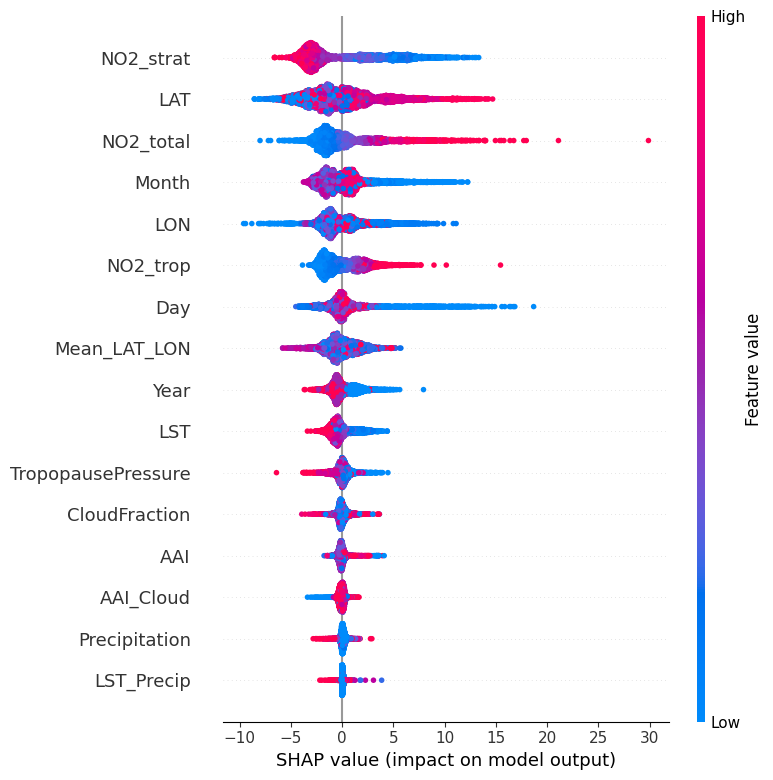

In [ ]:
# SHAP Explanation
import shap
explainer = shap.Explainer(cat_model, X_train)

# SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

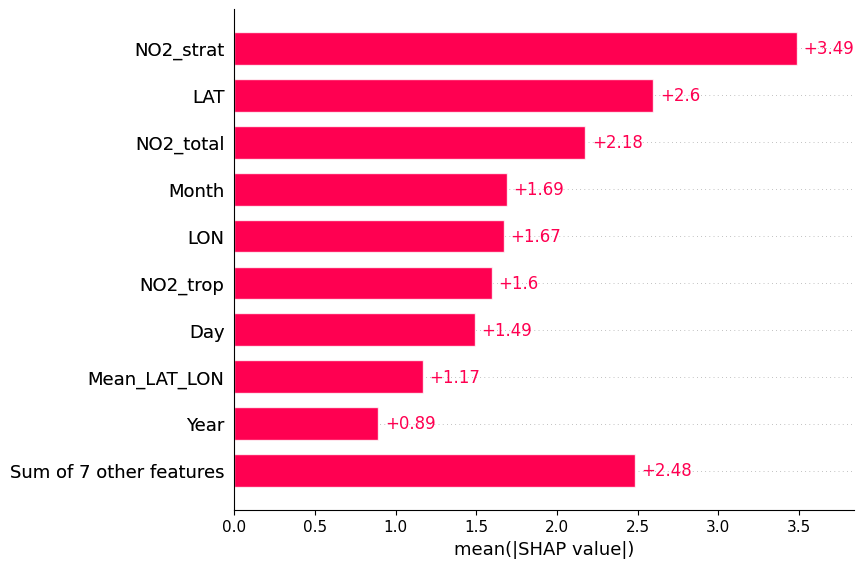

In [ ]:
# Feature Importance Bar Chart
shap.plots.bar(shap_values)

**LGB Regressor**

In [ ]:
pip install lightgbm


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb

# Define base models
xgb_model = XGBRegressor(n_estimators=12000, learning_rate=0.05, max_depth=7,
                         colsample_bytree=0.8, subsample=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=0.5)
lgb_model = lgb.LGBMRegressor(n_estimators=16000, learning_rate=0.1, num_leaves=31, verbose=-1)

# Define meta-model (XGBoost instead of Linear Regression)
meta_model = XGBRegressor(n_estimators=5000, learning_rate=0.03, max_depth=5,
                          colsample_bytree=0.7, subsample=0.8)

# Number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for out-of-fold predictions
train_meta_features = np.zeros((X_train.shape[0], 2))
test_meta_features = np.zeros((X_test.shape[0], 2))

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train base models
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],verbose=False)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

    # Generate out-of-fold predictions
    train_meta_features[val_index, 0] = xgb_model.predict(X_val)
    train_meta_features[val_index, 1] = lgb_model.predict(X_val)

    # Generate test predictions for averaging
    test_meta_features[:, 0] += xgb_model.predict(X_test) / kf.n_splits
    test_meta_features[:, 1] += lgb_model.predict(X_test) / kf.n_splits

# Train meta-model (XGBoost)
meta_model.fit(train_meta_features, y_train)

# Predict using the meta-model
y_pred_stacked = meta_model.predict(test_meta_features)

# Compute RMSE
stacking_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
print(f"Stacking Model with XGBoost Meta-Model RMSE: {stacking_rmse}")


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize and train the LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=10000, learning_rate=0.1, num_leaves=45, verbose=-1)
lgb_model.fit(X_train, y_train)

# Predictions
y_pred_test = lgb_model.predict(X_test)

# Compute Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Compute Test MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Print results
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")


Test RMSE: 7.19016484184531
Test MAE: 4.9026516776386755


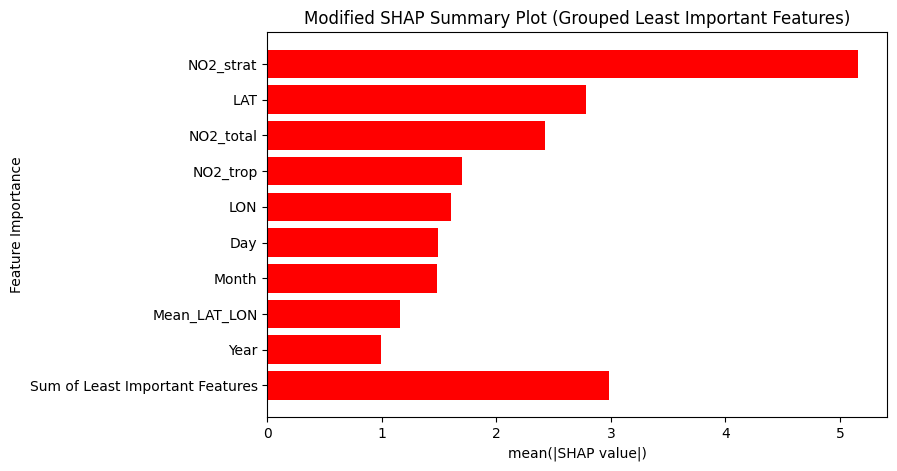

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values
shap_values_abs = np.abs(shap_values).mean(axis=0)

# Convert to DataFrame for easy handling
shap_importance = pd.DataFrame({'Feature': X_test.columns, 'SHAP_Value': shap_values_abs})
shap_importance = shap_importance.sort_values(by='SHAP_Value', ascending=False)

# Number of least important features to combine
num_least_important = 7

# Separate top features and least important features
top_features = shap_importance.iloc[:-num_least_important]
least_important_sum = shap_importance.iloc[-num_least_important:]['SHAP_Value'].sum()

# Create a new DataFrame for the combined feature
least_important_row = pd.DataFrame({'Feature': ['Sum of Least Important Features'], 'SHAP_Value': [least_important_sum]})

# Concatenate the two DataFrames
top_features = pd.concat([top_features, least_important_row], ignore_index=True)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top_features['Feature'], top_features['SHAP_Value'], color='red')
plt.xlabel("mean(|SHAP value|)")
plt.ylabel("Feature Importance")
plt.title("Modified SHAP Summary Plot (Grouped Least Important Features)")
plt.gca().invert_yaxis()  # Invert y-axis to match SHAP default style
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Assuming X_train, y_train, X_test, y_test are already defined

# Initialize CatBoost and LightGBM models
catboost_model = cb.CatBoostRegressor(iterations=9000, learning_rate=0.05, depth=12,
                                      l2_leaf_reg=5, bagging_temperature=1.5, verbose=0)
lightgbm_model = lgb.LGBMRegressor(n_estimators=10000, learning_rate=0.1, num_leaves=45, verbose=-1)
# Stacking using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features_train = np.zeros((X_train.shape[0], 2))
meta_features_test = np.zeros((X_test.shape[0], 2))
for train_idx, val_idx in kf.split(X_train):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]  # Use .iloc for row indexing
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
    # Train CatBoost
    catboost_model.fit(X_t, y_t, eval_set=(X_v, y_v), early_stopping_rounds=100, verbose=0)
    meta_features_train[val_idx, 0] = catboost_model.predict(X_v)
    # Train LightGBM
    lightgbm_model.fit(X_t, y_t, eval_set=[(X_v, y_v)])
    meta_features_train[val_idx, 1] = lightgbm_model.predict(X_v)
# Train both models on the full dataset for test predictions
catboost_model.fit(X_train, y_train, verbose=0)
meta_features_test[:, 0] = catboost_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
lightgbm_model.fit(X_train, y_train)
meta_features_test[:, 1] = lightgbm_model.predict(X_test)

# Train Meta-Learner (Ridge Regression)
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(meta_features_train, y_train)

# Final Predictions
final_predictions = meta_learner.predict(meta_features_test)

# Compute Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Stacked Model Test RMSE: {test_rmse:.4f}")
test_mae = mean_absolute_error(y_test, final_predictions)
print(f"Stacked Model Test MAE: {test_mae:.4f}")

Stacked Model Test RMSE: 6.9300
Stacked Model Test MAE: 4.6545


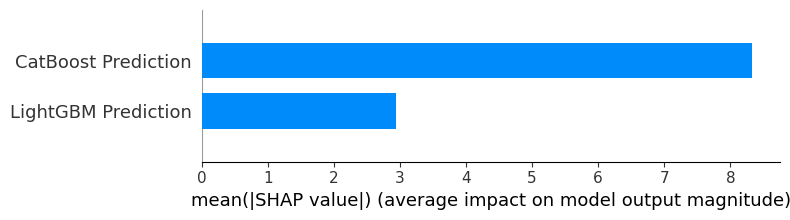

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(meta_learner, meta_features_train)

# Compute SHAP values
shap_values = explainer(meta_features_train)

# Feature names corresponding to CatBoost and LightGBM
feature_names = ["CatBoost Prediction", "LightGBM Prediction"]

# SHAP Summary Bar Plot
shap.summary_plot(shap_values, meta_features_train, feature_names=feature_names, plot_type="bar")
